## Using LSTMs To Find If A User Will Have Higher Or Lower Than Average Amount Of Sleep Based On Their Daily Routine

In [ ]:
#authored by Tom Odem on 19 November 2023

Guessing sleep amounts based on daily activity is apparently not a popular topic for LSTM architectures, so we had to be creative with our research. What we realized after some digging is that the problem of finding patterns in daily activities is a lot like finding patterns in writing. Earlier actions influence actions that come later and vice versa, just like words in sentences and paragraphs. Our LSTM architecture is based on the model found in the article written by Li, where they used an LSTM to categorize customer complaints into different product categories (Credit Card, Mortgage, Loans, etc). With some modifications to our data and the LSTM model described in the article, we were able to create an LSTM that predicts if a user will sleep more than or equal to the average sleep duration or if they would sleep less than the average.

Li, S. (2019, April 10). Multi-class text classification with LSTM. Medium. https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 

#### Imports

In [68]:
import modules
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import optimizers
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

#### Get data and turn it into data usable by LSTM

In [2]:
#Get data and then split it into sequences (X) and class (Y)
X = modules.get_and_dayitise_data()#read in data from csv and turn into day by day sequences
Y = np.array([x[0] for x in X]) #get the sleep times (1st column)
X = np.array([x[1:] for x in X]) #remove the sleep times

no user_tags: 501
no user_tags: 503
no user_tags: 507
no user_tags: 520
no user_tags: 523
no user_tags: 529
no user_tags: 532
no user_tags: 544
no user_tags: 547
no user_tags: 634
no user_tags: 658
no user_tags: 661
no user_tags: 662
no user_tags: 664
no user_tags: 668


For day-by-day data, our data is obtained via two different file models: user_information.csv, which lists every user who participated in the study, and user_tag files, which are individual files for each user that documents every action that was recorded throughout the study. The function get_and_dayitise_data() opens every user_tag file for each user, computes the amount of sleep the user had each day, and then groups daily actions together with their respective daily sleep amounts. What is returned is an array of arrays, where each subarray holds a single day's sleep amount followed by the actions performed during that day. The amount of days held in the array is equal to the amount of days where a daily sleep amount was obtained for every day for every user. Since we are trying to guess the amount of sleep based on daily activities, we take the first column of this array as our labels and everything proceeding as our data.

In [3]:
#get only the activity sequences that have more than some number of activities per day
length = len(Y)
lowest_num_activities = 3
Y = np.array([Y[i] for i in range(len(Y)) if len(X[i])>lowest_num_activities]) #update the Y to only include indices who's X length is greater than lowest_sum_activities
X = [x for x in X if len(x)>lowest_num_activities] #update X with only those indices whos number of activities is greater than lowest_num_activities
percent_length = len(Y)/length
print(f'percentage of data remaining: {percent_length}')

percentage of data remaining: 0.9230769230769231


Some days within our data just didn't have a lot of activities recorded, which is probably the fault of the students who labeled the data, rather than users actually performing less actions. Because of this, we designated any days that contained less than or equal to 3 activities to be outliers, and so removed them. We chose the number 3 because we believe that 4 or more activities can have a significant impact on a user's day. Additionally, we get more data to left over after only pruning data that have 3 or less activities. This left us with 92.3% of data points to train and test with.

In [4]:
#one hot encode Y to have 2 classes (less than average sleep or more than or equal average sleep)

#put Y values into 2 classes
average_sleep = np.mean(Y) #get the average amount of sleep
Y[Y < average_sleep] = 0 #less than average
Y[Y >= average_sleep] = 1 #more than or equal average

#one hot encode it so we have a larger dimensionality that will match the output of the LSTM
onehot_encoder = OneHotEncoder(categories='auto')
Y = onehot_encoder.fit_transform(Y.reshape(-1,1)).toarray()

print(average_sleep)

15.577676508104942


Because our LSTM model uses a softmax function to obtain a probability for multiple classes, we need to one hot encode the labels to be in multiple classes so that the LSTM can use them. Todo this we simply found the average amount of sleep within our labels and classified each label as 1 (more or equal to the average amount of sleep) or 0 (less than the average amount of sleep). Once our label array was a 1 dimensional array of 1s and 0s, we can now one hot encode it into a 2D array with two columns, each column representing 1 or 0. Our labels were now ready for the LSTM. For this population of users, the average amount of sleep was 15.58 hours of sleep (remember sleep amount is daily sleep amount, not nightly, and these are elderly persons!). This means that a user who slept more than or equal to 15.58 hours would be classified as 1 and all other users who slept less are classified as 0.  

In [5]:
#encode the X labels into numeric values. important note: each row is not the same length
le = LabelEncoder()
le.fit_transform(np.hstack(X)) #flatten X so we can fit the encoder to all possible values in each row
X = np.array([le.transform(x)+1 for x in X]) #now transform each row into corresponding encoding using the fitted encoder, add 1 so that we don't have any zeroes because 0 is for padding


Similarly to the labels, we had to encode the daily actions into integer representations so that the LSTM could read them. Since each action was one of a handful of set string values, we simply used the LabelEncoder object from sklearn to encode each string to an integer. We add 1 to each value to ensure that there is no 0 category, since the value of 0 will be used to pad the data in the next step and so signifies a "none" activity.

In [6]:
#resize the arrays to be of size average length
average_length = int(np.median([len(x) for x in X])) #get the average length
#if the length is less than the average, pad it with zeroes. if the length is over, resize it
X = np.array([np.resize(np.pad(x,(0,average_length-len(x))), average_length) if len(x) < average_length else np.resize(x,average_length) for x in X])

X.shape

(1488, 10)

To be used as input in our LSTM, each day had to be the same length. Unfortunately, each day in our dataset is of a different and random length determined by user actions. To create equal length input we first found the average length of all days. This is the length we want every day to be. So, we either padded days with less than the average-amount-of-actions with zeroes or took the first average-amount-of-actions actions from days with more than average-amount-of-actions actions. This gives us a dataset where each day is average-amount-of-actions in length.

#### Training the model

In [7]:
#split up our data into trains and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 68)

In [8]:
#test multiple models out and find which is the best


save_params = []
save_accuracy = []
embedding = 100 #helps with finding patterns in daily routines
num_unique_labels = len(le.classes_)+1
                #learning rate, epochs, dropout, batch_size, accuracy
best_results = [0.0,            0,      0.0,     0,          0.0] #saves the best results found throughout testing
#these are the various model parameters we will be trying
learning_rates = [.01,.02,.03,.05,.06,.07,.08,.09,.1]
epoch_rates = [5,10,15]
dropout_rates = [.01,.02,.03,.05,.06,.07,.08,.09,.1]
batch_sizes = [16,32,64]

for lr in learning_rates: #these loops try every combination of the above paramters sets, and will populate best_results 
    for epochs in epoch_rates:#with the paramaters that returns the best accuracy
        for dropout in dropout_rates:
            for batch_size in batch_sizes: 
                model = Sequential() #initialize the model
                model.add(Embedding(num_unique_labels, embedding, input_length=average_length)) #first layer is embedding, it will try to learn the daily activity patterns
                model.add(SpatialDropout1D(dropout)) #drop out feature maps to reduce overfitting
                model.add(LSTM(100, dropout=dropout, recurrent_dropout=dropout)) #LSTM layer
                model.add(Dense(2, activation='softmax')) #using softmax for possibility of multiple classes
                adam = optimizers.Adam(learning_rate=lr) #using Adam optimizer
                model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) #again using categorical_crossentropy for possibility of multiple classes

                #actually train the model, use a validation split of .1 and also allow the ability to early stop
                history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
                #evaluate the model we just trained and save it if it is better
                accuracy = model.evaluate(X_test,Y_test)
                save_accuracy.append(accuracy[1])
                save_params.append(f'{lr}, {epochs}, {dropout}, {batch_size}')
                if(accuracy[1] > best_results[4]): #the accuracy is the best we have seen so far, so save it
                    best_results = [lr, epochs, dropout, batch_size, accuracy[1]]

Epoch 1/5
76/76 [==============================] - 7s 23ms/step - loss: 0.3946 - accuracy: 0.8448 - val_loss: 0.3254 - val_accuracy: 0.8881
Epoch 2/5
76/76 [==============================] - 1s 13ms/step - loss: 0.3659 - accuracy: 0.8656 - val_loss: 0.2742 - val_accuracy: 0.9179
Epoch 3/5
76/76 [==============================] - 1s 14ms/step - loss: 0.3319 - accuracy: 0.8905 - val_loss: 0.2998 - val_accuracy: 0.9104
Epoch 4/5
76/76 [==============================] - 1s 14ms/step - loss: 0.3203 - accuracy: 0.8871 - val_loss: 0.3055 - val_accuracy: 0.8955
Epoch 5/5
5/5 [==============================] - 0s 4ms/step - loss: 0.3264 - accuracy: 0.8993
Epoch 1/5
38/38 [==============================] - 5s 19ms/step - loss: 0.4148 - accuracy: 0.8357 - val_loss: 0.3083 - val_accuracy: 0.8806
Epoch 2/5
38/38 [==============================] - 0s 10ms/step - loss: 0.3581 - accuracy: 0.8598 - val_loss: 0.3484 - val_accuracy: 0.8955
Epoch 3/5
38/38 [==============================] - 0s 9ms/step - 

Our LSTM model consists of an embedding layer that is used to find patterns between activities. Next the data goes through a 1 dimensional spatial dropout that drops feature maps from the data to reduce overfitting. This is followed by the LSTM layer. Finally, captured data goes to the output layer, which creates 2 output values based on the probability of having more or less than average sleep. We use softmax as our activation function so that we can get probabilities across these two classes, and categorical crossentropy as our loss function, again due to our multi-class predictions. While our final model is only a binary classifier, the original model was built to accept multiple classes in the case that we wanted to add more "bins" to the sleep classifications.

To get the best LSTM model, we tested multiple parameters and saved the best one. Todo this, we retrained and evaluated an LSTM for different values of learning rates, number of epochs, dropout rates, and batch sizes. The values we tested for each are as followed: learning rates = {.01,.02,.03,.05,.06,.07,.08,.09,.1}, number of epochs = {5,10,15}, dropout rates = {.01,.02,.03,.05,.06,.07,.08,.09,.1}, and batch sizes = {16,32,64}. Every permutation of these parameters was trained on a training set and evaluated based on a test set, with the best model being discriminated based on accuracy of the modle on the test set. This comes out to 729 models that were trained and evaluated.

Text(0.8322147727012634, -0.005, '0.09, 15, 0.07, 16')

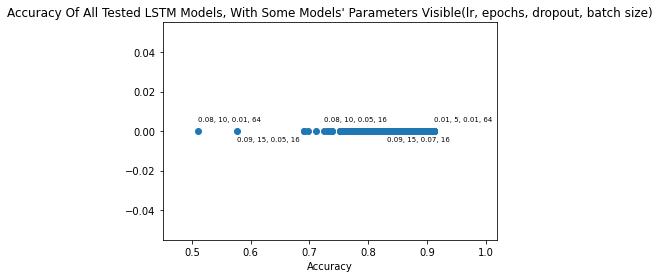

In [66]:
plt.title("Accuracy Of All Tested LSTM Models, With Some Models' Parameters Visible(lr, epochs, dropout, batch size)")
plt.xlabel('Accuracy')
plt.xlim(.45,1.02)
plt.scatter(save_accuracy,np.zeros_like(save_accuracy))

#print smallest accuracy params
plt.annotate(save_params[np.argmin(save_accuracy)], (np.min(save_accuracy),.005), fontsize = 7)

#print params of second lowest accuracy
second_smallest = np.partition(save_accuracy, 1)[1]
second_index = np.argpartition(save_accuracy, 1)[1]
plt.annotate(save_params[second_index], (second_smallest,-.005), fontsize = 7)

#print highest accuracy params
plt.annotate(save_params[np.argmax(save_accuracy)], (np.max(save_accuracy),.005), fontsize = 7)

#print params of some nth lowest accuracy
number = 6
middle_smallest = np.partition(save_accuracy, number)[number]
middle_index = np.argpartition(save_accuracy, number)[number]
plt.annotate(save_params[middle_index], (middle_smallest,.005), fontsize = 7)

number = 100
middle_smallest = np.partition(save_accuracy, number)[number]
middle_index = np.argpartition(save_accuracy, number)[number]
plt.annotate(save_params[middle_index], (middle_smallest,-.005), fontsize = 7)


#### Results

In [103]:
#define the best model that was found above and print it's model summary

#get the best paramaters
lr = best_results[0]
epochs = best_results[1]
dropout = best_results[2]
batch_size = best_results[3]

#define the model using the best parameters
model = Sequential()
model.add(Embedding(num_unique_labels, embedding, input_length=average_length))
model.add(SpatialDropout1D(dropout))
model.add(LSTM(100, dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(2, activation='softmax'))
adam = optimizers.Adam( learning_rate=lr)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())
print(f'\n--------------------------------------------------------\nbest model parameters: \nlearning rate- {best_results[0]}  \nepochs- {best_results[1]} \ndropout- {best_results[2]} \nbatch size- {best_results[3]}')

Model: "sequential_738"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_739 (Embedding)   (None, 10, 100)           1200      
                                                                 
 spatial_dropout1d_734 (Spat  (None, 10, 100)          0         
 ialDropout1D)                                                   
                                                                 
 lstm_737 (LSTM)             (None, 100)               80400     
                                                                 
 dense_767 (Dense)           (None, 2)                 202       
                                                                 
Total params: 81,802
Trainable params: 81,802
Non-trainable params: 0
_________________________________________________________________
None

--------------------------------------------------------
best model parameters: 
learning rate- 0.01  
epoch

Above you can see the model that achieved the best accuracy out of the 729 trained models and the output shape of each layer. The best found learning rate was .01, the best number of epochs were 5, the best dropout rate was .01, and the best batch size was 64. In the above model, each 10 in the embedding and dropout layer corresponds to the length of the day and the 2 in the output layer corresponds to the 2 classes we are classifying.

In [10]:
#train the best model and print it's accuracy
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
accuracy = model.evaluate(X_test,Y_test)
print(f'Test set\n  Loss: {accuracy[0]}\n  Accuracy: {accuracy[1]}')

Epoch 1/5


19/19 [==============================] - 3s 38ms/step - loss: 0.4106 - accuracy: 0.8232 - val_loss: 0.2785 - val_accuracy: 0.9030
Epoch 2/5
19/19 [==============================] - 0s 23ms/step - loss: 0.3342 - accuracy: 0.8888 - val_loss: 0.2790 - val_accuracy: 0.9179
Epoch 3/5
19/19 [==============================] - 0s 24ms/step - loss: 0.3253 - accuracy: 0.8871 - val_loss: 0.2809 - val_accuracy: 0.9104
Epoch 4/5
5/5 [==============================] - 0s 5ms/step - loss: 0.3131 - accuracy: 0.9128
Test set
  Loss: 0.31314876675605774
  Accuracy: 0.9127516746520996


This best found model has an accuracy of 89.26%. This means that given a 10 day sequence of a user's actions, our LSTM model can predict if that user will have more-than-or-equal-to or less-than the average sleep amount with respect to the population with 89.26% accuracy. As discussed above, the average amount of sleep for this population is 15.58 hours. So we are specifically predicting if a user sleeps more-than-or-equal-to or less-than 15.58 hours a day.